# Face Generation Project

In this project, a DCGAN is defined and trained on a dataset of faces. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible.

The project is broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, the results of the trained Generator are visualized to check performance; generated samples should look like fairly realistic faces with small amounts of noise.


### Data

[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is used to train the adversarial networks in this project.

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Only the images are needed for this project, which are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.


### Pre-processed Data

Since the project's main focus was building the GANs, Udacity provided a dataset a partially pre-processed dataset. Each of the CelebA images was cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is shown below.

<img src='processed_face_data.png' width=60% />

This data can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip) and is a smaller subset of the very large CelebA data. The zip file has to be extracted in the home directory of this notebook for loading and processing. After extracting the data, a directory with the data `processed_celeba_small/` should appear.

### Script

Udacity provided part of the script that had to be completed by the student. Student input is marked in the script with "input start" and "input end".

---
## 1.- Define data directory and import libraries

In [17]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

%matplotlib inline

---
## 2.- Preprocess data an create DatalLoader

A few other stpes were needed to **transform** this data and create a **DataLoader** such that the following requirements were met:

* Images should be square Tensor images of size `image_size x image_size` in the x and y dimension.
* 'get_dataloader' function should return a DataLoader that shuffles and batches these Tensor images.

To create a dataset given a directory of images, the use of PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper was recommended, with a root directory `processed_celeba_small/` and data transformation passed in.

A DataLoader `celeba_train_loader` was created with appropriate hyperparameters by calling the get_dataloader function. For this a reasonable `batch_size` parameter was chosen and image size was set to `32` as required by the projects rubric. Resizing the data to a small size allowed faster training, while still creating convincing images of faces.

In [4]:
# Define get_dataloader function

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # INPUT START
    
    # Implement transforms and return a dataloader
    
    trans = transforms.Compose([transforms.Resize((image_size, image_size)),
                                transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=trans)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    return dataloader


# Define function hyperparameters

batch_size = 128
img_size = 32

# INPUT END

# Call function to get dataloader

celeba_train_loader = get_dataloader(batch_size, img_size)

---
## 3.- Visualize the CelebA Data

Next, some images were visualized to check the correct implementation of the DataLoader. As expected, square images of somewhat-centered faces were obtained.

The Tensor images had to be converted into a NumPy type and the dimensions transposed to correctly display the image using `imshow`.

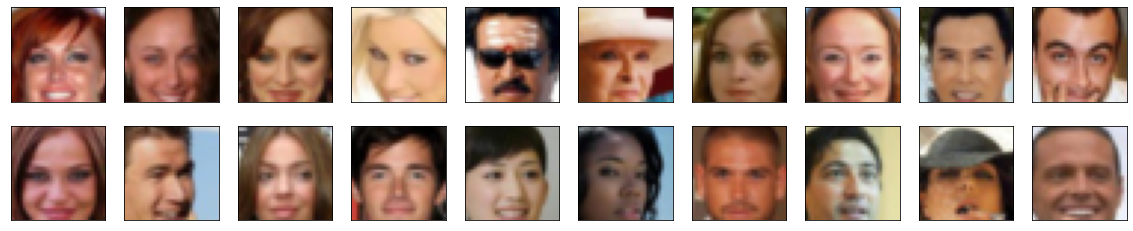

In [5]:
# INPUT START

# Define helper display function

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# INPUT END

# Obtain one batch of training images

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot the images in the batch

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

Further pre-processing was required. The output of a `tanh` activated generator contains pixel values in a range from -1 to 1. So training images were rescaled forma their original range (0-1) to a range of -1 to 1.

In [6]:
# INPUT START

# Define scale function

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # Scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x

# INPUT END

# Check scaled range (close to -1 to 1)

img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9529)


---
## 4.- Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## 4.1.- Discriminator

First, a deep network was defined in the discriminator class. The network is a convolutional classifier with normalization and no maxpooling layers. Inputs to the discriminator are 32x32x3 tensor images, and the ouput is a single value that indicates whether a given image is real or fake. Several helper functions were also defined.

In [7]:
# START INPUT

# Define heleper function for convolutional layers

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    layers.append(conv_layer)
    
    if batch_norm is True:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

# Define Discriminator class

class Discriminator(nn.Module):

    # Define init function
    
    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        # Convolutional layers
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = nn.Linear(2*2*conv_dim*8, 1)
                
    # Define forward function (feedforward behavior)
    
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        # Convolutional layers
       
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # Flatten input to fully connected layer
        
        x = x.view(-1, 2*2*self.conv_dim*8)
        
        # Fully connected layer
        
        x = self.fc(x)

        return x

# INPUT END

tests.test_discriminator(Discriminator)

Tests Passed


## 4.2.- Generator

The generator class upsamples an input and generates a *new* image of the same size as the training data `32x32x3`. To achive this mostly transpose convolutional layers with normalization applied to the outputs were used. The inputs are vectors of length `z_size`, and the output an image of shape `32x32x3`

In [9]:
# INPUT START

# Define helper function for transpose convolutional layers

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
    layers.append(deconv_layer)
    
    if batch_norm is True:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

# Define Generator class

class Generator(nn.Module):
    
    # Define init function
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # Linear layer
        
        self.fc = nn.Linear(z_size, 2 * 2 * conv_dim*8)
        
        # Transpose convolutional layers
        
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    # Define forward function (feedforward behavior)     

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """

        # Linear layer
        
        x = self.fc(x)
        
        # Reshape input to transpose convolutional layers
        
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        # Transpose convolutional layers
        
        x = F.relu(self.deconv1(x))        
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.tanh(self.deconv4(x))
        
        return x

# INPUT END

tests.test_generator(Generator)

Tests Passed


## 4.3.- Initialize the weights of the networks

To help the models converge, the weights of the convolutional and linear layers in the model were initialized. This was dobe following the same strategy as in the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf):
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

The weight initialization function met the following requirements:

* Only **convolutional** and **linear** layers were initialized.
* Weights were initialized to a normal distribution, centered around 0, with a standard deviation of 0.02.
* Existing bias terms were left alone or set to 0.

In [10]:
# Define weight initialization function

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    # INPUT START
    
    # Apply initial weights to convolutional and linear layers
    
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
    
    # INPUT END

## 4.4.- Build complete network

Here the models' hyperparameters were defined the discriminator and generator were instatiated from the classes defined above. 

In [11]:
# Define build_network function

def build_network(d_conv_dim, g_conv_dim, z_size):
    
    # Define discriminator and generator
    
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # Initialize model weights
    
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


# INPUT START

# Define model hyperparams

d_conv_dim = 128
g_conv_dim = 128
z_size = 128

# INPUT END

# Call build_network function

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=128, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, 

### Training on GPU check

Check if you can train on GPU. Here, we'll set this as A boolean variable `train_on_gpu` is set to check if GPU is available for training. Later, models, model inputs and loss function arguments were moved to GPU when appropriate.

In [12]:
# Check for a GPU

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


## 4.5.- Discriminator and Generator Losses

Here the functions needed to calculate the losses for both types of adversarial networks were defined.

### Discriminator Losses

For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
Losses were set up so that an output of 1 corresponded to real images and 0 to fake images.


### Generator Loss

The generator loss is similar to the discriminator losses but with flipped labels (the generator's goal is to get the discriminator to *think* its generated images are *real*).

### Loss error

**Least squares** error was used when defining the loss functions.

In [16]:
# INPUT START

# Define real_loss function

def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''

    loss = torch.mean((D_out - 1)**2)
    
    return loss

# Define fake_loss function

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    loss = torch.mean(D_out**2)
    
    return loss

# INPUT END

## 4.6.- Optimizers

Here the optimizers for the Discriminator (D) and Generator (G) are defined with appropriate hyperparameters.

In [48]:
# INPUT START

# Parameters

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# INPUT END

---
## 5.- Training

Training involves alternating between training the discriminator and the generator. `real_loss` and `fake_loss` functions are used to help calculate the discriminator losses. The discriminator is trained by alternating on real and fake images. The generator, which tries to trick the discriminator, has an opposing loss function to the discriminator.


Some code was provided to print out some loss statistics and save some generated "fake" samples.

In [20]:
# Define train function

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Move models to GPU
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated, "fake" samples
    
    samples = []
    losses = []

    # Get some fixed data for sampling for inspecting model performance
    
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # Move z to GPU if available
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Epoch training loop
    
    for epoch in range(n_epochs):

        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # INPUT START
            
            ### Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # Train with real images
           
            D_out_real = D(real_images)
            d_real_loss = real_loss(D_out_real)
            
            # Generate fake images
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Train with fake images
            
            D_out_fake = D(fake_images)
            d_fake_loss = fake_loss(D_out_fake)
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            ### Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Generate fake_images
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Train on fake images using flipped labels
            
            D_out_fake = D(fake_images)
            g_loss = real_loss(D_out_fake)
            
            g_loss.backward()
            g_optimizer.step()
                        
            # INPUT END

            # Print some loss stats
            
            if batch_i % print_every == 0:
                
                # Append discriminator loss and generator loss
                
                losses.append((d_loss.item(), g_loss.item()))
                
                # Print discriminator and generator loss
                
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        ### After each epoch
        
        # Generate and save sample fake images
        
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # Finally return losses
    
    return losses

## 5.1.- Training

Next, the number of training epochs is set and the train function is called to train the GAN!

In [55]:
# INPUT START

# Set number of epochs 
n_epochs = 200


# Call training function
losses = train(D, G, n_epochs=n_epochs)

# INPUT END

Epoch [    1/  200] | d_loss: 2.0930 | g_loss: 4.2350
Epoch [    1/  200] | d_loss: 0.1840 | g_loss: 1.3949
Epoch [    1/  200] | d_loss: 0.0879 | g_loss: 0.9049
Epoch [    1/  200] | d_loss: 0.0477 | g_loss: 1.1721
Epoch [    1/  200] | d_loss: 0.0314 | g_loss: 1.3516
Epoch [    1/  200] | d_loss: 0.0430 | g_loss: 1.8064
Epoch [    1/  200] | d_loss: 0.0163 | g_loss: 1.2436
Epoch [    1/  200] | d_loss: 0.0697 | g_loss: 1.5961
Epoch [    1/  200] | d_loss: 0.0109 | g_loss: 1.1417
Epoch [    1/  200] | d_loss: 0.1361 | g_loss: 2.1645
Epoch [    1/  200] | d_loss: 0.0077 | g_loss: 1.1027
Epoch [    1/  200] | d_loss: 0.1362 | g_loss: 0.4511
Epoch [    1/  200] | d_loss: 0.0090 | g_loss: 1.1627
Epoch [    1/  200] | d_loss: 0.0094 | g_loss: 1.0380
Epoch [    1/  200] | d_loss: 0.0069 | g_loss: 1.3088
...Epoch [  200/  200] | d_loss: 0.1067 | g_loss: 1.6022
Epoch [  200/  200] | d_loss: 0.0102 | g_loss: 1.0125
Epoch [  200/  200] | d_loss: 0.0773 | g_loss: 1.2054
Epoch [  200/  200] | d_l

## 5.2.- Plot training loss

The losses recorded after each epoch for the generator and discriminator are plotted.

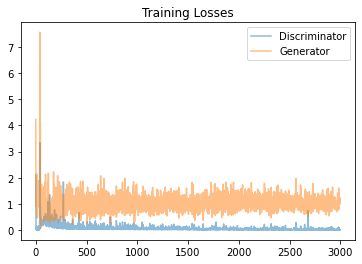

In [56]:
# Plot losses

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## 5.3.- View generator samples from training

Some samples of images from the generator are viewed.

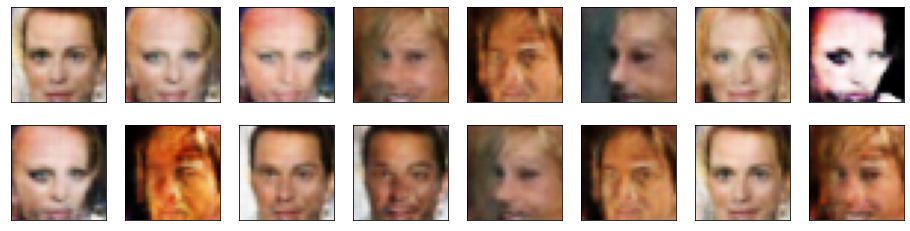

In [59]:
# Helper function for viewing a list of passed in sample images

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
# Load samples from generator, taken while training

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# View samples

_ = view_samples(-1, samples)

---
## 6.- Result discussion

The generated samples are very similar in between, are all of white people, and present similar features or characteristics. If we consider the model trained with celebrity images, which are mostly white (as can be observed in previewed data at the beginning of this notebook), this results were to be expected. In addition, model size is quite humble, which only allowed it to learn a limited number of features. The variability of fixed_z could also be conditioning the variability of the generated faces.

The number of epochs seemed to be adequate, as both generator and discriminator losses stabilized after 100 epochs. Better results could be obtained with higher resolution inputs (reduced blurriness) or a deeper network (enhanced feature extraction), but would probably require algorithm for more epochs. Additionally, training with a larger dataset, with a sample that was more representative world's population, could yield results that are more realistic and varied.

The selected optimizers seemed to work appropriately, as we obtained realistic faces with acceptable quality considering the characteristics of the training dataset and the deepness of the model.